In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import r2_score
import tqdm
import pybedtools
import seaborn as sns

plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False
import cooltools.lib.plotting
from scipy.stats import t

/tmp/ipykernel_1885221/2473772257.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Order RNA

In [2]:
RNAmat = pd.read_csv("./RNAumimat.tsv.gz", sep="\t")
RNAmat = RNAmat.set_index("gene")

# select gene more than 10% cell expressed
RNAmat = RNAmat[(RNAmat>=1).sum(axis=1)/RNAmat.shape[1] > 0.1].copy()

In [3]:
metadata = pd.read_csv("../data/metadata/metadata.tsv", sep="\t")
cellcycle_metadata = metadata[['cellname','cellcycle_phase','order']].copy()
cellcycle_metadata.sort_values("order",inplace=True)

In [4]:
RNAmat = RNAmat.loc[:,cellcycle_metadata["cellname"].values]
RNArolling = RNAmat.T.rolling(window=200,center=True,min_periods=1).mean().T

In [5]:
def polynomial_fit_and_evaluate(vec, degree=2):
    x = np.arange(len(vec))
    y = np.array(vec)
    
    coeffs = np.polyfit(x, y, degree)

    p = np.poly1d(coeffs)

    y_pred = p(x)

    r_squared = r2_score(y, y_pred)
    
    return coeffs, r_squared

# fit for all peaks
coeffs_all = []
r_squared_all = []
for i in tqdm.tqdm(range(RNArolling.shape[0])):
    vec = RNArolling.iloc[i].values
    coeffs, r_squared = polynomial_fit_and_evaluate(vec, degree=3)
    coeffs_all.append(coeffs)
    r_squared_all.append(r_squared)

100%|██████████| 10403/10403 [00:12<00:00, 801.23it/s] 


Text(0.5, 1.0, 'Distribution of R^2 values')

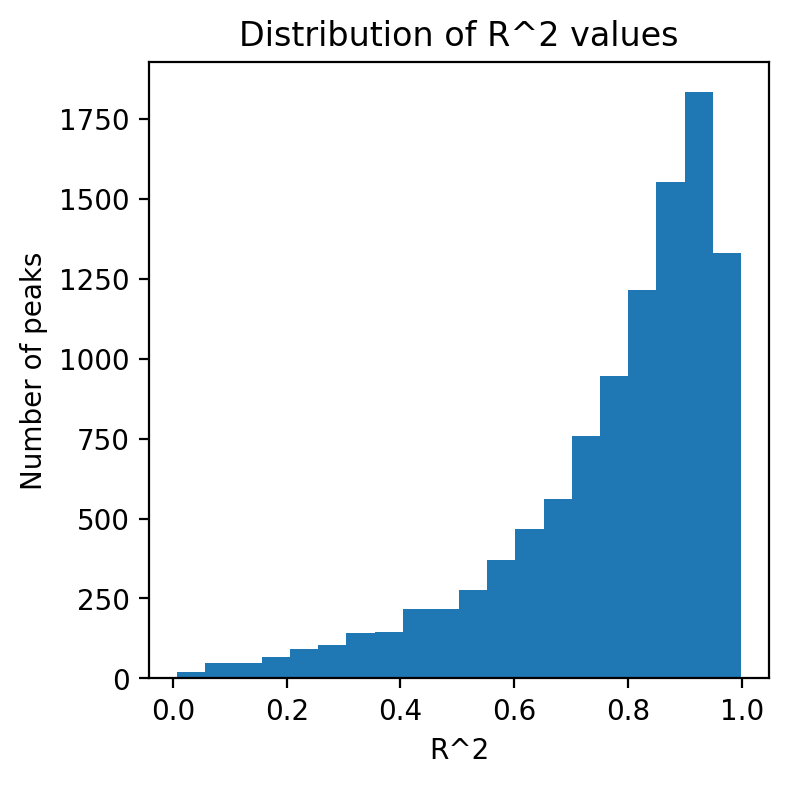

In [6]:
# histogram of R^2 values
plt.figure(figsize=(4,4))
plt.hist(r_squared_all, bins=20)
plt.xlabel("R^2")
plt.ylabel("Number of peaks")
plt.title("Distribution of R^2 values")

In [7]:
#from scipy.stats import kendalltau
def calc_order(vec):
    norm_vec = vec / np.sum(vec)
    return np.dot(norm_vec, np.linspace(0,1,len(vec)))

rnamat_order = RNArolling.copy()
#rnamat_order = rnamat_order.iloc[np.array(r_squared_all) > 0.6,:]
rnaorder = rnamat_order.apply(calc_order,axis = 1)

rnaorder = rnaorder.sort_values(ascending=True)
rnamat_order = rnamat_order.loc[rnaorder.index]

rnamat_order_raw = rnamat_order.copy()
# z-score normalization on each row
# rnamat_order = rnamat_order.apply(lambda x: (x - x.mean()) / x.std(),axis=1)

# min-max normalization on each row
rnamat_order = rnamat_order.apply(lambda x: (x - x.min()) / (x.max() - x.min()),axis=1)

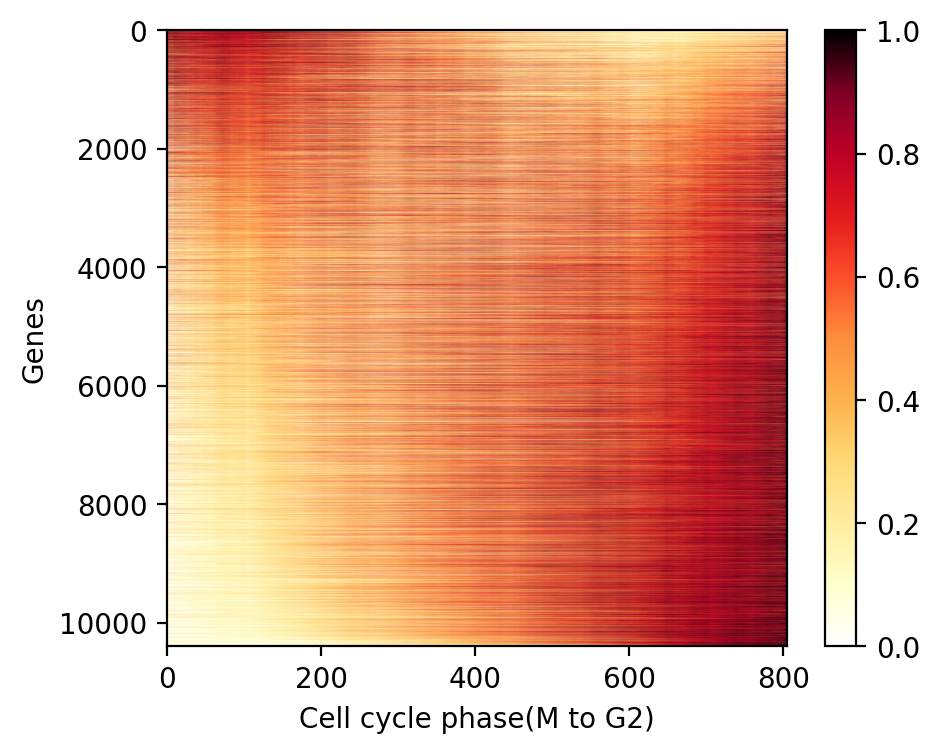

In [8]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(5,4))
plt.imshow(rnamat_order,cmap="fall",aspect="auto",vmin=0,vmax=1)
plt.xlabel("Cell cycle phase(M to G2)")
plt.ylabel("Genes")
plt.colorbar()

plt.savefig("figures/smoothed_RNA_expression.pdf",bbox_inches="tight")

# Order ATAC

In [9]:
#atac_peaks = pd.read_csv("../../data/publicdata/ENCODE/ENCFF048DWN_encode_mESCE14_DNase.bed.gz",sep="\t",header=None).iloc[:,0:3]
atac_peaks = pd.read_csv("../1_preprocess/atacpeak_score50.bed",sep="\t",header=None)
atac_peaks.columns = ["chrom","start","end"]
atac_peaks = atac_peaks[atac_peaks["chrom"].str.contains("chr")]

atac_peaks["start"] = atac_peaks["start"] - 200
atac_peaks["end"] = atac_peaks["end"] + 200

# atac_frags = pd.read_csv("../../data/fragments/atac.fragments.bgz",sep="\t",header=None)#.iloc[:,0:3]
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte
atac_frags = pd.read_csv("../data/fragments/atac.fragments.bgz",sep="\t",header=None,compression='gzip')
atac_frags.columns = ["chrom","start","end","cellname","count"]

chrom_length = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/mm10.chr.len",sep="\t",header=None)
chrom_length.columns = ["chrom","length"]

In [10]:
fragment_in_peak = pybedtools.BedTool.from_dataframe(atac_peaks).intersect(pybedtools.BedTool.from_dataframe(atac_frags),wa=True,wb=True).to_dataframe()

temp = fragment_in_peak.iloc[:,[0,1,2,6]].groupby(["chrom","start","end","thickStart"]).size().reset_index()
temp.columns = ["chrom","start","end","cellname","count"]
temp = temp.pivot_table(index=["chrom","start","end"],columns="cellname",values="count",fill_value=0)

atac_peakmat = temp.loc[:,cellcycle_metadata["cellname"].values]
atac_peakmat_raw = atac_peakmat.copy()
atac_peakmat = atac_peakmat.T.rolling(window=200,center=True,min_periods=1).mean().T

***** WARNING: File /tmp/pybedtools.v2l9rbpm.tmp has inconsistent naming convention for record:
GL456210.1	705	817	P4067	1

Error: Invalid record in file /tmp/pybedtools.wmgo_31p.tmp. Record is 
chrM	-83	1853


In [99]:
atac_peakmat = atac_peakmat.T.rolling(window=200,center=True,min_periods=1).mean().T

Polynomial coefficients: [-1.28113457e-10  2.21377950e-07 -3.92385049e-05  2.46982824e-02]
R^2: 0.7937499611719381


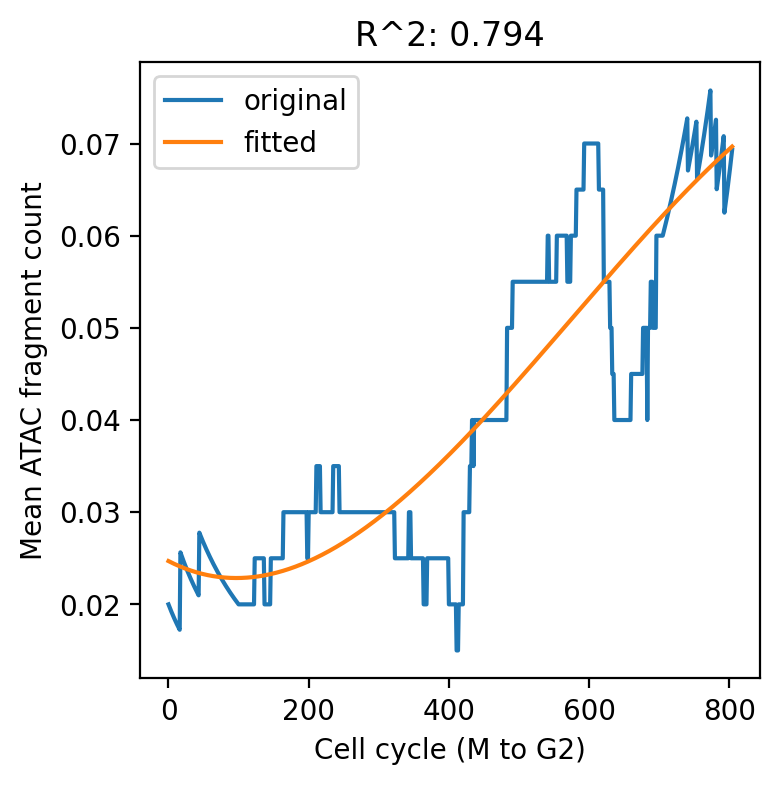

In [100]:
vec = atac_peakmat.iloc[2502].values
coeffs, r_squared = polynomial_fit_and_evaluate(vec, degree=3)
print("Polynomial coefficients:", coeffs)
print("R^2:", r_squared)


# plot the fitted curve
x = np.arange(len(vec))
y = np.array(vec)
p = np.poly1d(coeffs)
y_pred = p(x)

plt.figure(figsize=(4,4))
plt.plot(x, y, label="original")
plt.plot(x, y_pred, label="fitted")
plt.xlabel("Cell cycle (M to G2)")
plt.ylabel("Mean ATAC fragment count")
plt.title("R^2: %.3f" % r_squared)
plt.legend()
plt.show()

In [12]:
# fit for all peaks
coeffs_all = []
r_squared_all = []
for i in tqdm.tqdm(range(atac_peakmat.shape[0])):
    vec = atac_peakmat.iloc[i].values
    coeffs, r_squared = polynomial_fit_and_evaluate(vec, degree=3)
    coeffs_all.append(coeffs)
    r_squared_all.append(r_squared)

100%|██████████| 87726/87726 [01:17<00:00, 1134.14it/s]


Text(0.5, 1.0, 'Distribution of R^2 values')

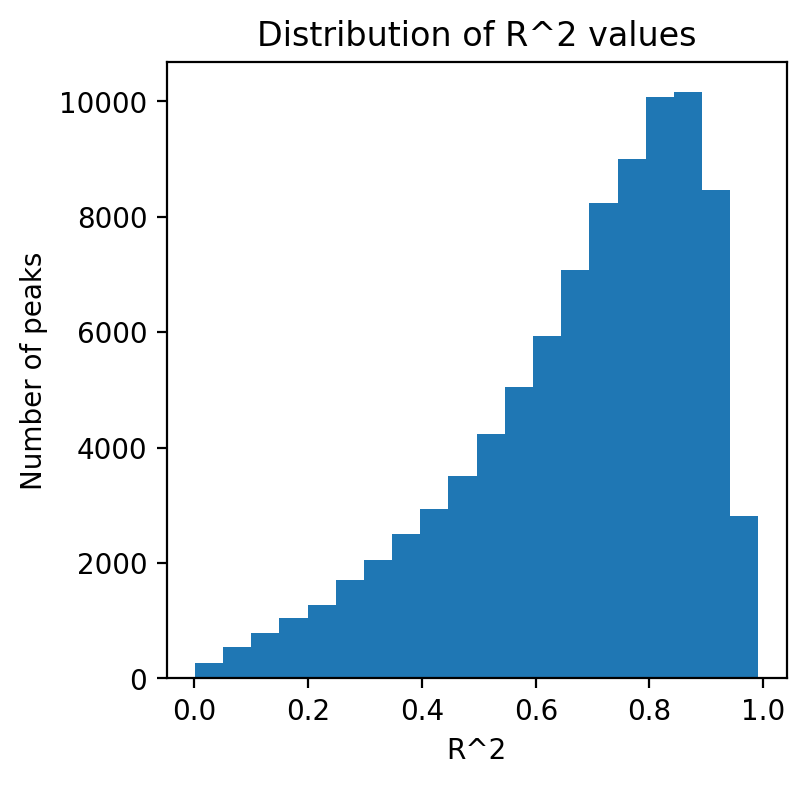

In [13]:
# histogram of R^2 values
plt.figure(figsize=(4,4))
plt.hist(r_squared_all, bins=20)
plt.xlabel("R^2")
plt.ylabel("Number of peaks")
plt.title("Distribution of R^2 values")

In [14]:
well_fit_peak_mat = atac_peakmat.copy()
def calc_order(vec):
    norm_vec = vec / np.sum(vec)
    return np.dot(norm_vec, np.linspace(0,1,len(vec)))

# reorder rows 
atacmat_order = well_fit_peak_mat.copy()
atacorder = atacmat_order.apply(calc_order,axis = 1)

atacorder = atacorder.sort_values(ascending=True)
atacmat_order = well_fit_peak_mat.loc[atacorder.index]

atacmat_order_raw = atacmat_order.copy()
# z-score normalization on each row
# atacmat_order = atacmat_order.apply(lambda x: (x - x.mean()) / x.std(),axis=1)
# min-max normalization on each row
atacmat_order = atacmat_order.apply(lambda x: (x - x.min()) / (x.max() - x.min()),axis=1)

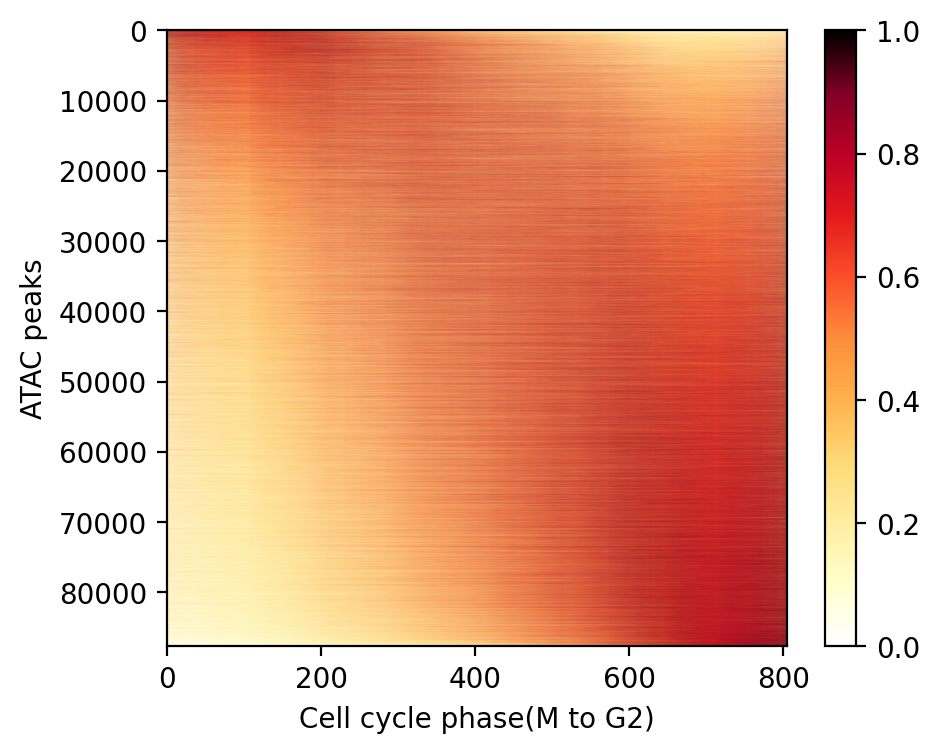

In [15]:
plt.figure(figsize=(5,4))
plt.imshow(atacmat_order,cmap="fall",aspect="auto",vmin=0,vmax=1)
plt.colorbar()
plt.xlabel("Cell cycle phase(M to G2)")
plt.ylabel("ATAC peaks")

# save to pdf
plt.savefig("figures/smoothed_atac_peak_expression.pdf",bbox_inches="tight")


In [16]:
temp_atacmat_order = atac_peakmat_raw.loc[atacorder.index].reset_index().copy()
temp_atacmat_order["genome_coord"] = temp_atacmat_order["chrom"] + ":" + temp_atacmat_order["start"].astype(str) + "-" + temp_atacmat_order["end"].astype(str)
# drop 
temp_atacmat_order = temp_atacmat_order.drop(columns=["chrom","start","end"])
temp_atacmat_order.set_index("genome_coord",inplace=True)

temp_atacmat_order = temp_atacmat_order.T.reset_index().merge(
    cellcycle_metadata[["cellname","cellcycle_phase"]],
    on="cellname"
).drop(columns=["cellname"]).groupby("cellcycle_phase").mean().T

/tmp/ipykernel_1885221/1493050223.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cellcycle_phase",y="value",data=boxplot_pdata,order=["M","G1","Early-S","Mid-S","Late-S","G2"],palette=["#ea6e34","#762a83","#99d8c9","#66c2a4","#41ae76","#238b45"],width=0.6,showfliers=False)


Text(0, 0.5, 'Normalized ATAC signal')

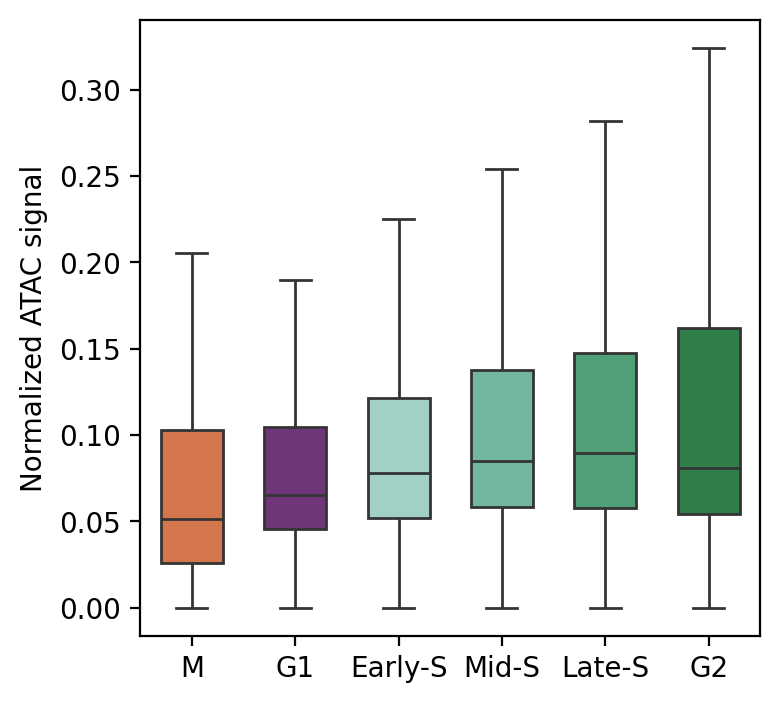

In [21]:
boxplot_pdata = temp_atacmat_order[["Early-S","Mid-S","Late-S","G2","M","G1"]].copy()
boxplot_pdata = boxplot_pdata.melt()
boxplot_pdata.columns = ["cellcycle_phase","value"]
# boxplot
plt.figure(figsize=(4,4))

sns.boxplot(x="cellcycle_phase",y="value",data=boxplot_pdata,order=["M","G1","Early-S","Mid-S","Late-S","G2"],palette=["#ea6e34","#762a83","#99d8c9","#66c2a4","#41ae76","#238b45"],width=0.6,showfliers=False)

plt.xlabel("")
plt.ylabel("Normalized ATAC signal")



/tmp/ipykernel_1885221/1094056044.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recover_region_stat.index,y=recover_region_stat.values,


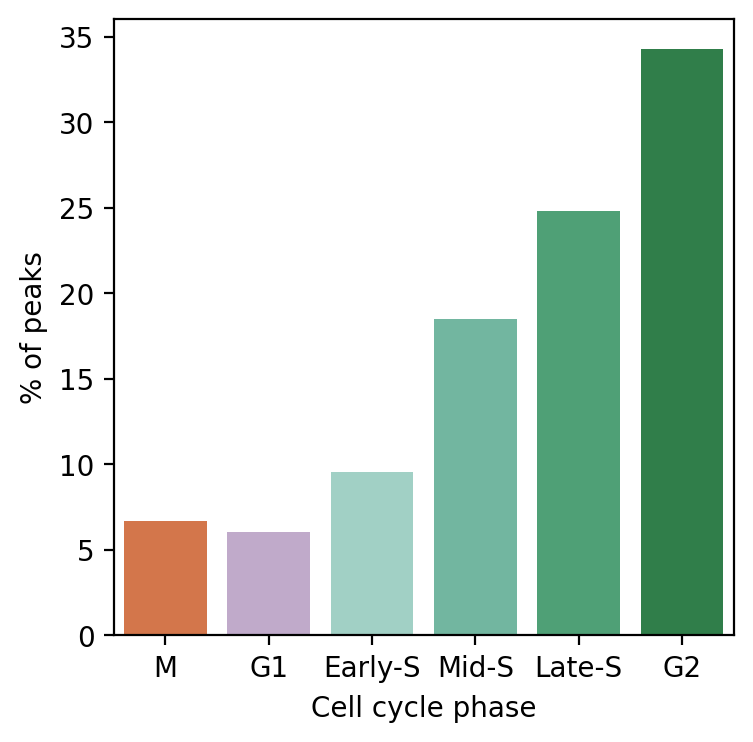

In [77]:
temp_atacmat_order["max"] = temp_atacmat_order.idxmax(axis=1)
recover_region_stat = temp_atacmat_order.groupby("max").size() / temp_atacmat_order.shape[0] * 100

plt.figure(figsize=(4,4))
sns.barplot(x=recover_region_stat.index,y=recover_region_stat.values,
            palette={"G1":"#c2a5cf","Early-S":"#99d8c9","Mid-S":"#66c2a4","Late-S":"#41ae76","G2":"#238b45","M":"#ea6e34"},
            order=["M","G1","Early-S","Mid-S","Late-S","G2"])
plt.ylabel("% of peaks")
plt.xlabel("Cell cycle phase")
plt.savefig("figures/atacpeak_recovery_cellcycle.pdf",bbox_inches="tight")
plt.show()

In [19]:
replitime_data = pd.read_csv("/shareb/zliu/analysis/CHARMtools/ref/mm10_repli_chip.wig.gz",header = None,sep = "\t",compression = "gzip")
replitime_data.columns = ["chrom","start","end","value"]
data100k = replitime_data.copy()
data100k["start"] = data100k["start"] // 100000 * 100000
data100k["end"] = data100k["start"] + 100000
data100k = data100k.groupby(["chrom","start","end"]).mean().reset_index()
# equally split data100k into 6 bins based on value
data100k["group"] = pd.qcut(data100k["value"],3,labels=False)

# intersect with data100k atacmat_order.reset_index()[["chrom","start","end"]]
data100k_bed = pybedtools.BedTool.from_dataframe(data100k)
atac_peakmat_bed = pybedtools.BedTool.from_dataframe(atac_peakmat.reset_index()[["chrom","start","end"]])

intersected = data100k_bed.intersect(atac_peakmat_bed,wa=True,wb=True).to_dataframe()
intersected = intersected[["strand","thickStart","thickEnd","score"]]
intersected.columns = ["chrom","start","end","group"]

#atacbyrep = atacmat_order.reset_index().merge(intersected,on=["chrom","start","end"],how="left").drop(columns=["chrom","start","end"]).groupby("group").mean()
#atacbyrep.index = np.array(["Late replicate","Middle replicate","Early replicate"])

In [20]:
pdata = atacmat_order.reset_index().merge(intersected,on=["chrom","start","end"],how="left").drop(columns=["chrom","start","end"]).set_index("group")
pdata.columns = np.arange(1,pdata.shape[1]+1)
pdata = pdata.reset_index().melt(id_vars=["group"])

In [58]:
atacbyrep = (atacmat_order.reset_index()
             .merge(intersected, on=["chrom","start","end"], how="left")
             .drop(columns=["chrom","start","end"])
             .groupby("group")
             .mean())
atacbyrep.index = np.array(["Late replicate","Middle replicate","Early replicate"])

grouped = (atacmat_order.reset_index()
           .merge(intersected, on=["chrom","start","end"], how="left")
           .drop(columns=["chrom","start","end"])
           .groupby("group"))

mean = grouped.mean()
std = grouped.std()
count = grouped.count()

se = std / np.sqrt(count)
dof = count - 1
alpha = 0.05
t_values = t.ppf(1 - alpha/2, dof)
half_width = t_values * se
lower = mean - half_width
upper = mean + half_width
mean.index = atacbyrep.index
lower.index = atacbyrep.index
upper.index = atacbyrep.index
atacbyrep_with_ci = pd.concat({
    'mean': mean,
    'lower': lower,
    'upper': upper
}, axis=1)

print(atacbyrep_with_ci)

                      mean                                                    \
                     P1026     P5062    P10041     P7044     P6054     P7061   
Late replicate    0.308303  0.308628  0.311676  0.312278  0.312711  0.315464   
Middle replicate  0.261033  0.261569  0.263128  0.264177  0.264405  0.267226   
Early replicate   0.243749  0.243937  0.244393  0.245547  0.245678  0.249074   

                                                          ...     upper  \
                     P7012     P2085     P1059    P10057  ...     P5025   
Late replicate    0.314572  0.314908  0.315190  0.318521  ...  0.671312   
Middle replicate  0.266157  0.266172  0.266838  0.271463  ...  0.633634   
Early replicate   0.248073  0.248109  0.248928  0.254540  ...  0.574638   

                                                                              \
                     P7011     P8030     P1093     P4092     P7081     P6087   
Late replicate    0.671473  0.674369  0.676677  0.679076  0.678

In [59]:
atacbyrep_with_ci

mean                                                    \
                     P1026     P5062    P10041     P7044     P6054     P7061   
Late replicate    0.308303  0.308628  0.311676  0.312278  0.312711  0.315464   
Middle replicate  0.261033  0.261569  0.263128  0.264177  0.264405  0.267226   
Early replicate   0.243749  0.243937  0.244393  0.245547  0.245678  0.249074   

                                                          ...     upper  \
                     P7012     P2085     P1059    P10057  ...     P5025   
Late replicate    0.314572  0.314908  0.315190  0.318521  ...  0.671312   
Middle replicate  0.266157  0.266172  0.266838  0.271463  ...  0.633634   
Early replicate   0.248073  0.248109  0.248928  0.254540  ...  0.574638   

                                                                              \
                     P7011     P8030     P1093     P4092     P7081     P6087   
Late replicate    0.671473  0.674369  0.676677  0.679076  0.678633  0.680967   
Middle replicate  0.632259  0.633835  0.633720  0.635029  0.633612  0.633627   
Early replicate   0.573887  0.575721  0.575003  0.576087  0.574751  0.574670   

                                                
                     P9087     P6075     P3066  
Late replicate    0.678078  0.677758  0.678181  
Middle replicate  0.633855  0.632297  0.631936  
Early replicate   0.576624  0.575120  0.575542  

[3 rows x 2415 columns]

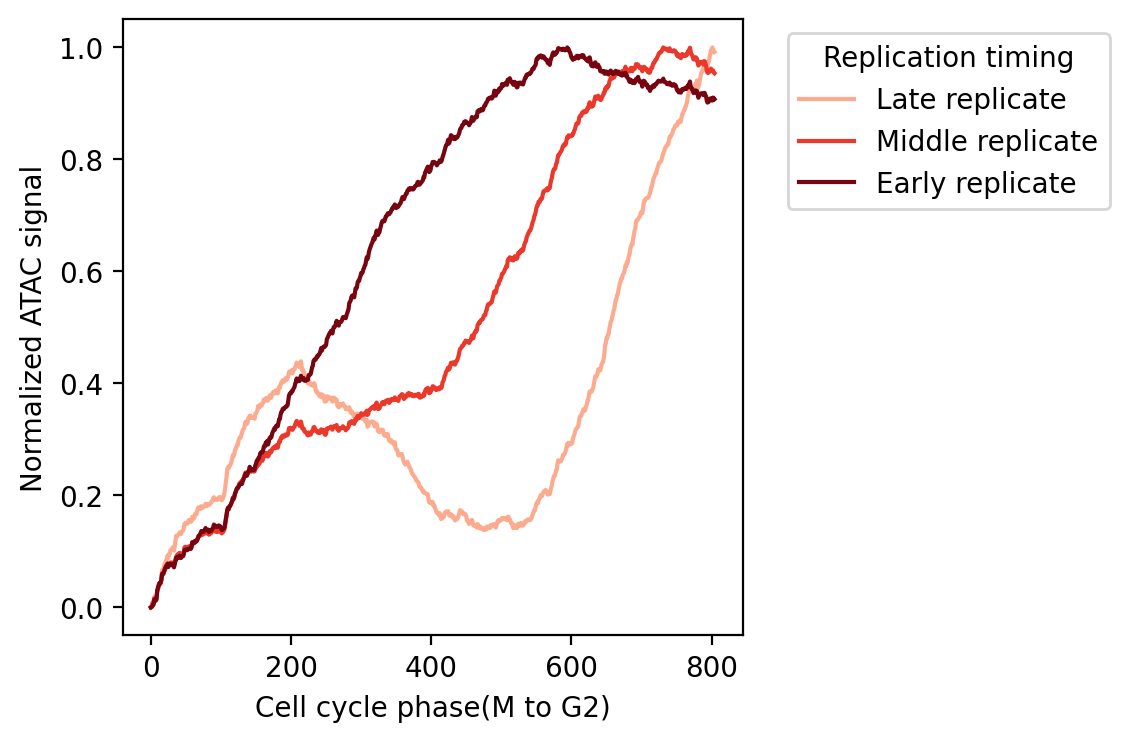

In [60]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(4,4))
for index,row in enumerate(atacbyrep.index):
    # min_max normalize on vec
    vec = atacbyrep.loc[row,:]
    vec = (vec - vec.min()) / (vec.max() - vec.min())
    plt.plot(np.arange(atacbyrep.shape[1]),vec,label=row,c = plt.cm.Reds(index/3 + 0.3))

plt.legend(title="Replication timing",bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Cell cycle phase(M to G2)")
plt.ylabel("Normalized ATAC signal")

plt.savefig("figures/atac_peak_signal_by_repli_time.pdf",bbox_inches="tight")

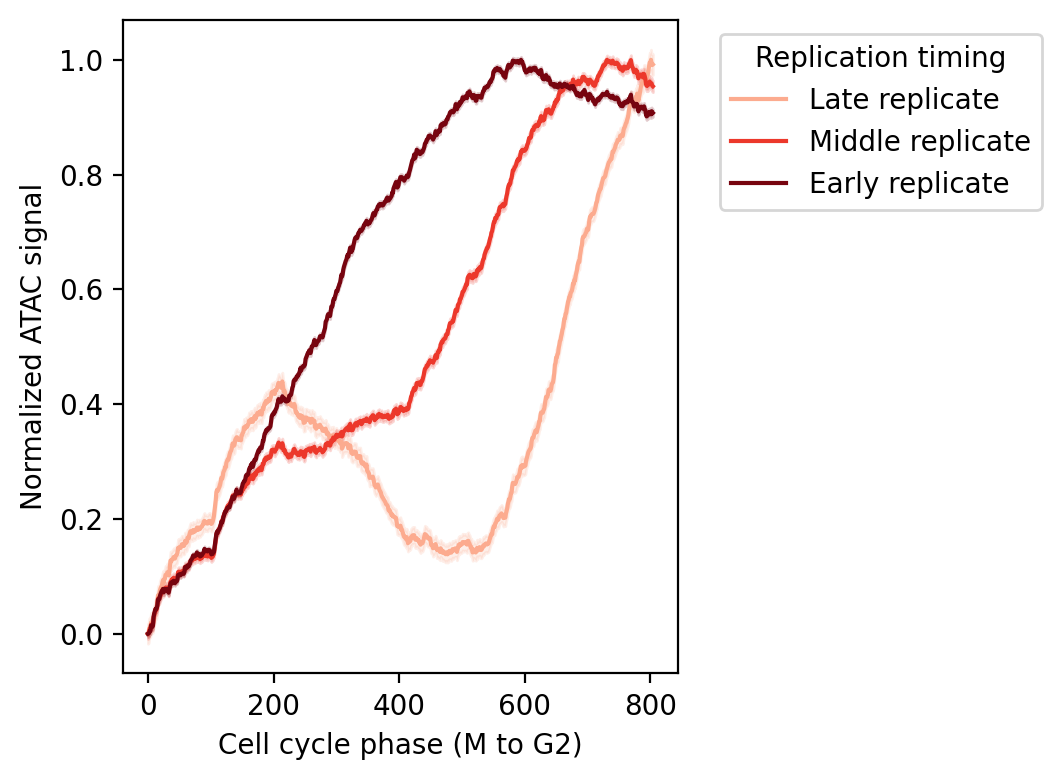

In [61]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(6.5, 4))

atac_mean = atacbyrep_with_ci['mean']
atac_upper = atacbyrep_with_ci['upper']
atac_lower = atacbyrep_with_ci['lower']

for i, row_name in enumerate(atac_mean.index):
    mean_vec = atac_mean.loc[row_name, :]
    upper_vec = atac_upper.loc[row_name, :]
    lower_vec = atac_lower.loc[row_name, :]
    vec_min = mean_vec.min()
    vec_max = mean_vec.max()
    
    norm_mean = (mean_vec - vec_min) / (vec_max - vec_min)
    norm_upper = (upper_vec - vec_min) / (vec_max - vec_min) 
    norm_lower = (lower_vec - vec_min) / (vec_max - vec_min) 

    x_values = np.arange(atac_mean.shape[1])
    color = plt.cm.Reds(i / 3 + 0.3)

    plt.plot(x_values, norm_mean, label=row_name, c=color)
    plt.fill_between(x_values, norm_lower, norm_upper, color=color, alpha=0.2)

plt.legend(title="Replication timing", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Cell cycle phase (M to G2)")
plt.ylabel("Normalized ATAC signal")
plt.tight_layout(rect=[0, 0, 0.85, 1]) 

plt.savefig("figures/atac_peak_signal_by_repli_time_with_CI.pdf", bbox_inches="tight")

plt.show()

## RNA relationship with ATAC

In [124]:
order_atac_peaks = atacmat_order.reset_index()[["chrom","start","end"]]
order_atac_peaks["order"] = np.arange(order_atac_peaks.shape[0])
genes = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",sep="\t",header=None)
genes.columns = ["chrom","start","end","id","gene","strand"]
considered_chroms = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10",
                    "chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18",
                    "chr19","chrX"]
genes.query('chrom in @considered_chroms',inplace=True)
# extend gene upstream 100kb
genes["start"] = genes.apply(lambda x: x["start"] - 20000 if x["strand"] == "+" else x["start"],axis=1)
genes["end"] = genes.apply(lambda x: x["end"] + 20000 if x["strand"] == "-" else x["end"],axis=1)

order_atac_peaks_bed = pybedtools.BedTool.from_dataframe(order_atac_peaks)
genes_bed = pybedtools.BedTool.from_dataframe(genes)
intersect_with_genes = order_atac_peaks_bed.intersect(genes_bed,wa=True,wb=True).to_dataframe()
intersect_with_genes = intersect_with_genes[["chrom","start","end","name","itemRgb"]]
intersect_with_genes.columns = ["chrom","start","end","order","gene"]

MG1genes = pd.read_csv("./MG1_genes.txt",sep="\t",header=None)
MG1genes["group"] = "M/G1"
EarlyMidSgenes = pd.read_csv("./EarlyMidS_genes.txt",sep="\t",header=None)
EarlyMidSgenes["group"] = "Early/Mid-S"
LateSG2genes = pd.read_csv("./LateSG2_genes.txt",sep="\t",header=None)
LateSG2genes["group"] = "Late-S/G2"

genegroups_df = pd.concat([MG1genes,EarlyMidSgenes,LateSG2genes])
genegroups_df.columns = ["gene","group"]

pdata = intersect_with_genes.merge(genegroups_df,on="gene",how="inner")

/tmp/ipykernel_2079906/2419844775.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="group",y="order",data=pdata,order=["M/G1","Early/Mid-S","Late-S/G2"],palette={"M/G1":"#c2a5cf","Early/Mid-S":"#66c2a4","Late-S/G2":"#238b45"},width=0.6)


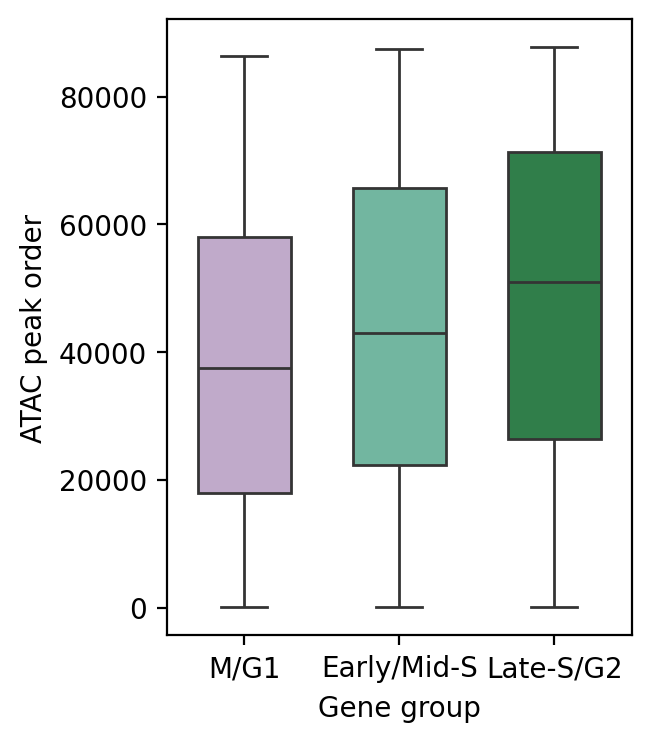

In [126]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(3,4))
#sns.boxplot(x="group",y="order",data=pdata,order#["group1","group234","Histones","group567","group8"])
# colors: cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")
# M/G1 color : #c2a5cf Early/Mid-S color : #66c2a4 Late-S/G2 color : #238b45
sns.boxplot(x="group",y="order",data=pdata,order=["M/G1","Early/Mid-S","Late-S/G2"],palette={"M/G1":"#c2a5cf","Early/Mid-S":"#66c2a4","Late-S/G2":"#238b45"},width=0.6)
plt.xlabel("Gene group")
plt.ylabel("ATAC peak order")

# save to pdf
plt.savefig("figures/gene_group_order.pdf",bbox_inches="tight")

# H3K27me3

In [62]:
h3k27me3_peak_bruce4 = pd.read_csv("../data/publicdata/ENCODE/ENCFF008XKX_encode_mESCBruce4_H3K27me3.bed.gz",sep="\t",header=None).iloc[:,0:3]
h3k27me3_peak_bruce4.columns = ["chrom","start","end"]
# extent
h3k27me3_peak_bruce4["start"] = h3k27me3_peak_bruce4["start"] - 2000
h3k27me3_peak_bruce4["end"] = h3k27me3_peak_bruce4["end"] + 2000
h3k27me3_peak_bruce4 = h3k27me3_peak_bruce4[h3k27me3_peak_bruce4["start"] > 0]

h3k4me3_peak = pd.read_csv("../data/publicdata/ENCODE/ENCFF247GVM_encode_mESCBruce4_H3K4me3.bed.gz",sep="\t",header=None).iloc[:,0:3]
h3k4me3_peak.columns = ["chrom","start","end"]

# generate bivalent
# combine overlapping peaks
h3k27me3_peak_bruce4_bed = pybedtools.BedTool.from_dataframe(h3k27me3_peak_bruce4)
h3k27me3_peak_bruce4_bed = h3k27me3_peak_bruce4_bed.sort()
h3k27me3_peak_bruce4_bed = h3k27me3_peak_bruce4_bed.merge()
h3k27me3_peak_bruce4 = h3k27me3_peak_bruce4_bed.to_dataframe()

# bivalent region is intersection of H3K27me3 and H3K4me3, return full region
bivalent_region = pybedtools.BedTool.from_dataframe(h3k27me3_peak_bruce4).intersect(pybedtools.BedTool.from_dataframe(h3k4me3_peak),wa=True).to_dataframe().drop_duplicates()
h3k27me3_only = h3k27me3_peak_bruce4.merge(bivalent_region,indicator=True,how='left').query('_merge == "left_only"').iloc[:,0:3]

In [63]:
bivalent_region.to_csv("bivalent_region.bed",sep="\t",header=False,index=False)

In [64]:
print("Number of bivalent region: ",bivalent_region.shape[0])
print("Number of H3K27me3 only region: ",h3k27me3_only.shape[0])

Number of bivalent region:  2876
Number of H3K27me3 only region:  2939


In [65]:
h3k27me3_only.to_csv("h3k27me3_only.bed",sep="\t",header=False,index=False)

In [66]:
h3k27me3_only["length"] = h3k27me3_only["end"] - h3k27me3_only["start"]
h3k27me3_only.sort_values("length",ascending=False).head(10)

,chrom,start,end,length
3617,chr4,65230591,65259151,28560
1013,chr11,96362725,96384912,22187
1095,chr11,112951034,112970175,19141
3467,chr3,137543592,137562216,18624
4991,chr8,57399443,57415591,16148
4926,chr8,46212703,46226723,14020
2586,chr18,79997791,80011761,13970
1179,chr12,35888923,35902841,13918
1093,chr11,112863799,112876971,13172
3018,chr2,116547783,116560800,13017


In [67]:
ct_frags = pd.read_csv("../data/fragments/ct.fragments.bgz",sep="\t",header=None,compression='gzip')
ct_frags.columns = ["chrom","start","end","cellname","count"]
fragment_in_peak = pybedtools.BedTool.from_dataframe(h3k27me3_peak_bruce4).intersect(pybedtools.BedTool.from_dataframe(ct_frags),wa=True,wb=True).to_dataframe()
temp = fragment_in_peak.iloc[:,[0,1,2,6]].groupby(["chrom","start","end","thickStart"]).size().reset_index()
temp.columns = ["chrom","start","end","cellname","count"]
temp = temp.pivot_table(index=["chrom","start","end"],columns="cellname",values="count",fill_value=0)

***** WARNING: File /tmp/pybedtools.tvuvg7ni.tmp has inconsistent naming convention for record:
GL456210.1	700	812	P7093	1

***** WARNING: File /tmp/pybedtools.tvuvg7ni.tmp has inconsistent naming convention for record:
GL456210.1	700	812	P7093	1



In [73]:
cellcycle_metadata_ct = cellcycle_metadata.copy()
cellcycle_metadata_ct['order'] = np.where(cellcycle_metadata_ct['order']>=193, cellcycle_metadata_ct['order']-193, cellcycle_metadata_ct['order']-193+805)
cellcycle_metadata_ct.sort_values("order",inplace=True)
#cellcycle_metadata_ct = cellcycle_metadata_ct.query('cellcycle_phase not in ["M","G1"]')


In [78]:
bivalent_index = bivalent_region.set_index(["chrom","start","end"]).index
h3k27me3_index = h3k27me3_only.set_index(["chrom","start","end"]).index

bivalent_mat = temp.loc[temp.index.intersection(bivalent_index),cellcycle_metadata_ct["cellname"].values]
h3k27me3_mat = temp.loc[temp.index.intersection(h3k27me3_index),cellcycle_metadata_ct["cellname"].values]

h3k27me3_mat.iloc[:,-193:] = h3k27me3_mat.iloc[:,-193:] * 2
bivalent_mat.iloc[:,-193:] = bivalent_mat.iloc[:,-193:] * 2

In [79]:
bivalent_vec = bivalent_mat.T.rolling(window=200,center=True,min_periods=1).mean().T.mean(axis=0).values
h3k27me3only_vec = h3k27me3_mat.T.rolling(window=200,center=True,min_periods=1).mean().T.mean(axis=0).values

# min-max normalization
bivalent_vec = (bivalent_vec - bivalent_vec.min()) / (bivalent_vec.max() - bivalent_vec.min())
h3k27me3only_vec = (h3k27me3only_vec - h3k27me3only_vec.min()) / (h3k27me3only_vec.max() - h3k27me3only_vec.min())


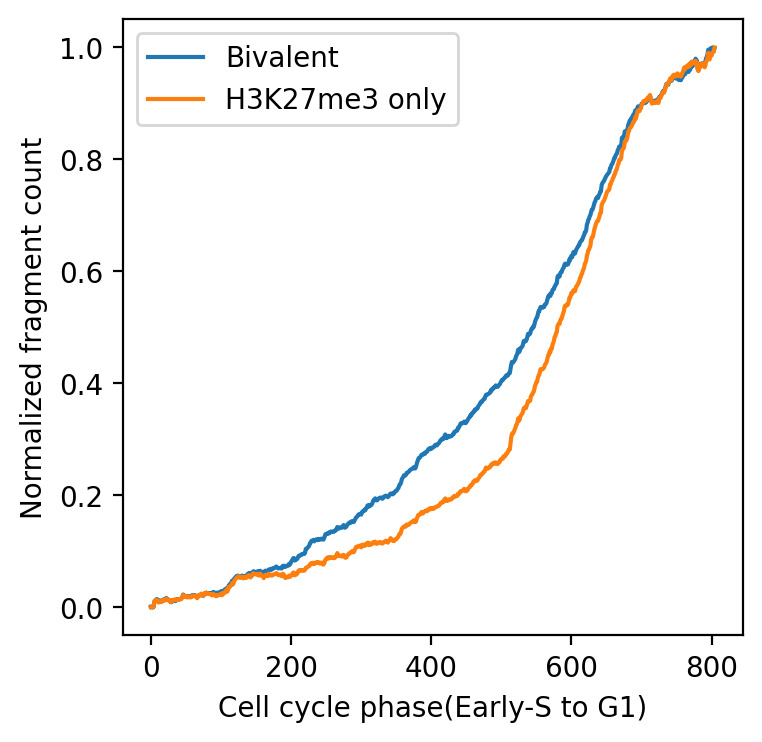

In [80]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4,4))
plt.plot(bivalent_vec,label="Bivalent")
plt.plot(h3k27me3only_vec,label="H3K27me3 only")
plt.xlabel("Cell cycle phase(Early-S to G1)")
plt.ylabel("Normalized fragment count")
plt.legend()

# save to pdf
plt.savefig("figures/h3k27me3_signal_dynamics.pdf",bbox_inches="tight")
#plt.show()

In [81]:
highsig_mat = temp.loc[temp.sum(axis=1).sort_values(ascending=False).head(1000).index,cellcycle_metadata_ct["cellname"].values]
lowsig_mat = temp.loc[temp.sum(axis=1).sort_values(ascending=True).head(1000).index,cellcycle_metadata_ct["cellname"].values]

highsig_mat.iloc[:,-193:] = highsig_mat.iloc[:,-193:] * 2
lowsig_mat.iloc[:,-193:] = lowsig_mat.iloc[:,-193:] * 2

highsig_vec = highsig_mat.T.rolling(window=200,center=True,min_periods=1).mean().T.mean(axis=0).values
lowsig_vec = lowsig_mat.T.rolling(window=200,center=True,min_periods=1).mean().T.mean(axis=0).values

# min-max normalization
highsig_vec = (highsig_vec - highsig_vec.min()) / (highsig_vec.max() - highsig_vec.min())
lowsig_vec = (lowsig_vec - lowsig_vec.min()) / (lowsig_vec.max() - lowsig_vec.min())

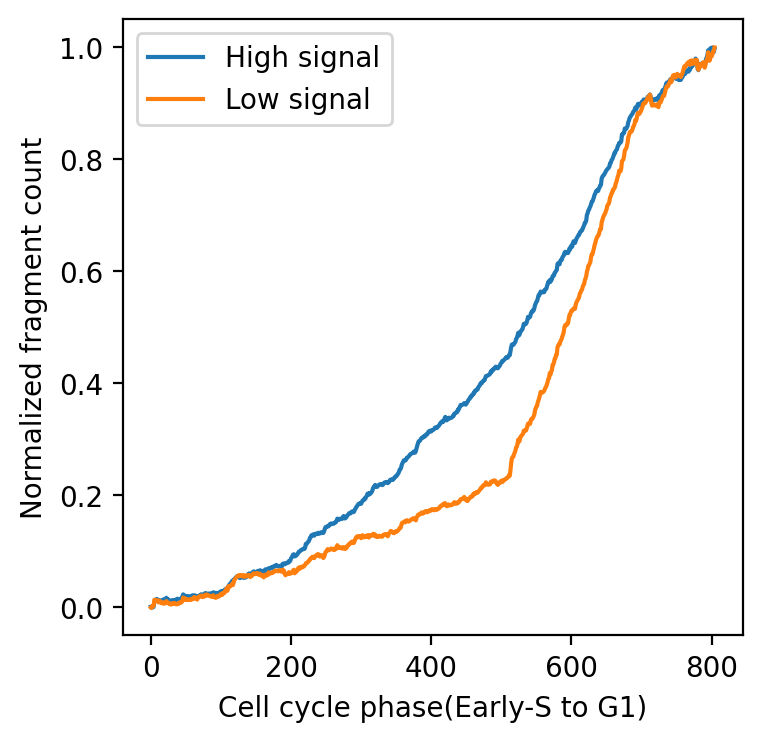

In [82]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4,4))
plt.plot(highsig_vec,label="High signal")
plt.plot(lowsig_vec,label="Low signal")
plt.xlabel("Cell cycle phase(Early-S to G1)")
#plt.xlabel("Cell cycle phase(M to G2)")
plt.ylabel("Normalized fragment count")

plt.legend()
plt.savefig("figures/h3k27me3_signal_dynamics_high_low.pdf",bbox_inches="tight")
plt.show()

In [85]:
h3k27me3_peakmat = temp.loc[:,cellcycle_metadata_ct["cellname"].values]
h3k27me3_peakmat.iloc[:,-192:] = h3k27me3_peakmat.iloc[:,-192:] * 2
h3k27me3_peakmat_raw = h3k27me3_peakmat.copy()

h3k27me3_peakmat = h3k27me3_peakmat.T.rolling(window=200,center=True,min_periods=1).mean().T
def calc_order(vec):
    norm_vec  = vec / np.mean(vec)
    return np.dot(norm_vec, np.arange(len(vec)) + 1)

# reorder rows 
ctmat_order = h3k27me3_peakmat.copy()
ctorder = ctmat_order.apply(calc_order,axis = 1)
ctorder = ctorder.sort_values()
ctmat_order = h3k27me3_peakmat.loc[ctorder.index]

# z-score normalization on each row
#ctmat_order = ctmat_order.apply(lambda x: (x - x.mean()) / x.std(),axis=1)
ctmat_order = ctmat_order.apply(lambda x: (x - x.min()) / (x.max() - x.min()),axis=1)

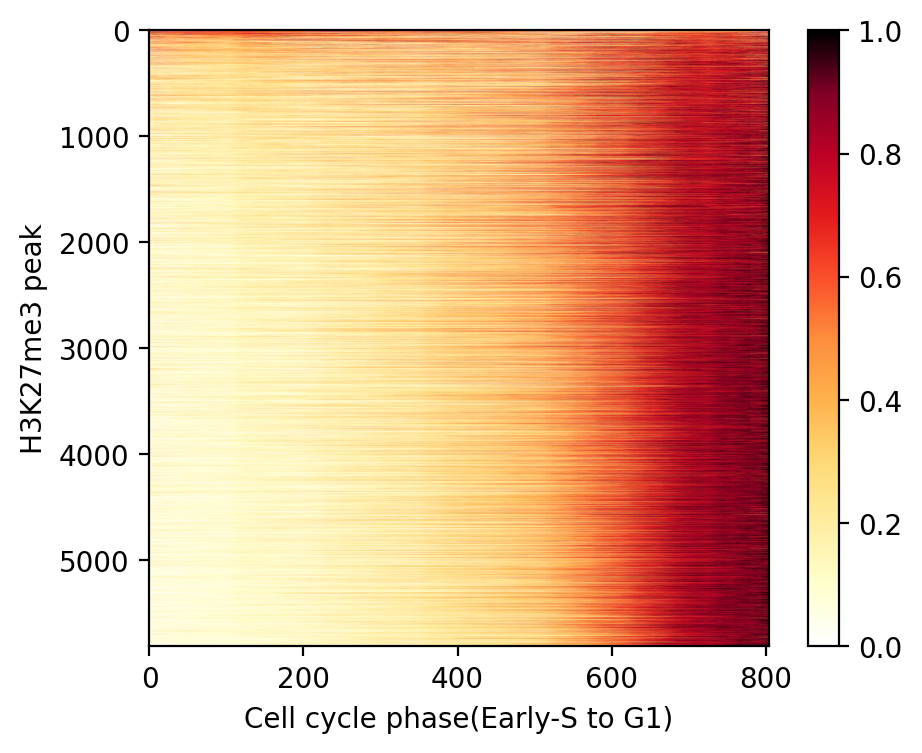

In [86]:
plt.figure(figsize=(5,4))
plt.imshow(ctmat_order,cmap="fall",aspect="auto",vmin=0,vmax=1)
plt.xlabel("Cell cycle phase(Early-S to G1)")
#plt.xlabel("Cell cycle order(M to G2)")
plt.ylabel("H3K27me3 peak")
plt.colorbar()

plt.savefig("figures/smoothed_h3k27me3_peak_expression.pdf",bbox_inches="tight")


In [87]:
temp_ctmat_order = h3k27me3_peakmat_raw.loc[ctorder.index].reset_index().copy()
temp_ctmat_order["genome_coord"] = temp_ctmat_order["chrom"] + ":" + temp_ctmat_order["start"].astype(str) + "-" + temp_ctmat_order["end"].astype(str)
# drop 
temp_ctmat_order = temp_ctmat_order.drop(columns=["chrom","start","end"])
temp_ctmat_order.set_index("genome_coord",inplace=True)

temp_ctmat_order = temp_ctmat_order.T.reset_index().merge(
    cellcycle_metadata_ct[["cellname","cellcycle_phase"]],
    on="cellname"
).drop(columns=["cellname"]).groupby("cellcycle_phase").mean().T

/tmp/ipykernel_1885221/4210460319.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cellcycle_phase",y="value",data=boxplot_pdata,order=["Early-S","Mid-S","Late-S","G2","M","G1"],palette=["#99d8c9","#66c2a4","#41ae76","#238b45","#ea6e34","#762a83"],width=0.6,showfliers=False)


Text(0, 0.5, 'Normalized H3K27me3 signal')

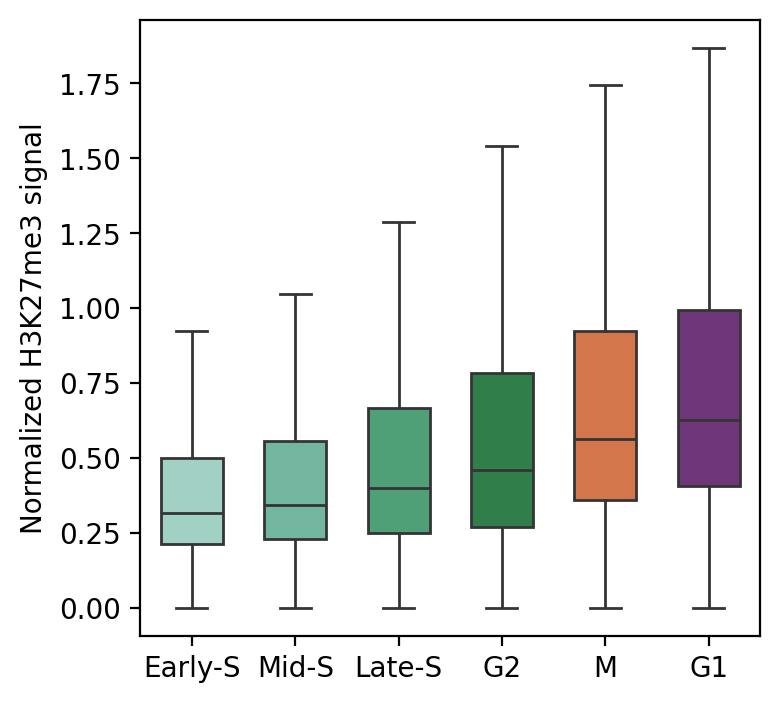

In [88]:
boxplot_pdata = temp_ctmat_order[["Early-S","Mid-S","Late-S","G2","M","G1"]].copy()
boxplot_pdata = boxplot_pdata.melt()
boxplot_pdata.columns = ["cellcycle_phase","value"]
# boxplot
plt.figure(figsize=(4,4))

sns.boxplot(x="cellcycle_phase",y="value",data=boxplot_pdata,order=["Early-S","Mid-S","Late-S","G2","M","G1"],palette=["#99d8c9","#66c2a4","#41ae76","#238b45","#ea6e34","#762a83"],width=0.6,showfliers=False)

plt.xlabel("")
plt.ylabel("Normalized H3K27me3 signal")



In [262]:
# # for each row, get **column name** of max value
# temp_ctmat_order = h3k27me3_peakmat.loc[ctorder.index].reset_index().copy()
# temp_ctmat_order["genome_coord"] = temp_ctmat_order["chrom"] + ":" + temp_ctmat_order["start"].astype(str) + "-" + temp_ctmat_order["end"].astype(str)
# # drop 
# temp_ctmat_order = temp_ctmat_order.drop(columns=["chrom","start","end"])
# temp_ctmat_order.set_index("genome_coord",inplace=True)

# temp_ctmat_order = temp_ctmat_order.T.reset_index().merge(
#     cellcycle_metadata_ct[["cellname","cellcycle_phase"]],
#     on="cellname"
# ).drop(columns=["cellname"]).groupby("cellcycle_phase").mean().T

# temp_ctmat_order["max"] = temp_ctmat_order.idxmax(axis=1)
# recover_region_stat = temp_ctmat_order.groupby("max").size() / temp_ctmat_order.shape[0] * 100

/tmp/ipykernel_1885221/2544096726.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recover_region_stat.index,y=recover_region_stat.values,


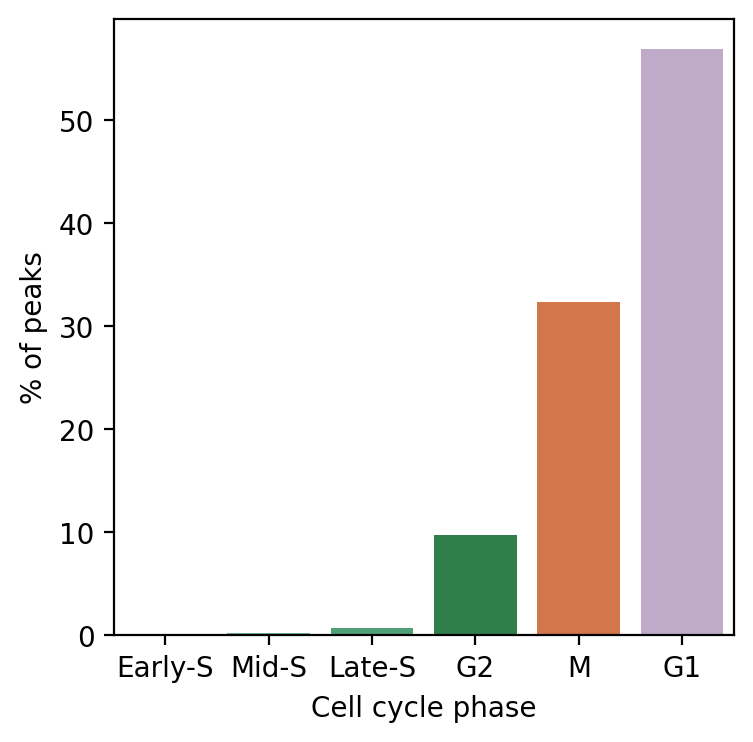

In [89]:
temp_ctmat_order["max"] = temp_ctmat_order.idxmax(axis=1)
recover_region_stat = temp_ctmat_order.groupby("max").size() / temp_ctmat_order.shape[0] * 100

plt.figure(figsize=(4,4))
sns.barplot(x=recover_region_stat.index,y=recover_region_stat.values,
            palette={"G1":"#c2a5cf","Early-S":"#99d8c9","Mid-S":"#66c2a4","Late-S":"#41ae76","G2":"#238b45","M":"#ea6e34"},
            order=["Early-S","Mid-S","Late-S","G2","M","G1"])
plt.ylabel("% of peaks")
plt.xlabel("Cell cycle phase")
plt.savefig("figures/h3k27me3_peak_recovery_cellcycle.pdf",bbox_inches="tight")
plt.show()

In [91]:
replitime_data = pd.read_csv("/shareb/zliu/analysis/CHARMtools/ref/mm10_repli_chip.wig.gz",header = None,sep = "\t",compression = "gzip")
replitime_data.columns = ["chrom","start","end","value"]
data100k = replitime_data.copy()
data100k["start"] = data100k["start"] // 100000 * 100000
data100k["end"] = data100k["start"] + 100000
data100k = data100k.groupby(["chrom","start","end"]).mean().reset_index()
# equally split data100k into 6 bins based on value
data100k["group"] = pd.qcut(data100k["value"],3,labels=False)

# intersect with data100k atacmat_order.reset_index()[["chrom","start","end"]]
data100k_bed = pybedtools.BedTool.from_dataframe(data100k)
ct_peakmat_bed = pybedtools.BedTool.from_dataframe(h3k27me3_peakmat.reset_index()[["chrom","start","end"]])

intersected = data100k_bed.intersect(ct_peakmat_bed,wa=True,wb=True).to_dataframe()
intersected = intersected[["strand","thickStart","thickEnd","score"]]
intersected.columns = ["chrom","start","end","group"]

In [92]:
intersected.groupby("group").size()

group
0    1269
1    2089
2    2795
dtype: int64

In [93]:
ctbyrep = ctmat_order.reset_index().merge(intersected,on=["chrom","start","end"],how="left").drop(columns=["chrom","start","end"]).groupby("group").mean()
ctbyrep.index = np.array(["Late replicate","Middle replicate","Early replicate"])

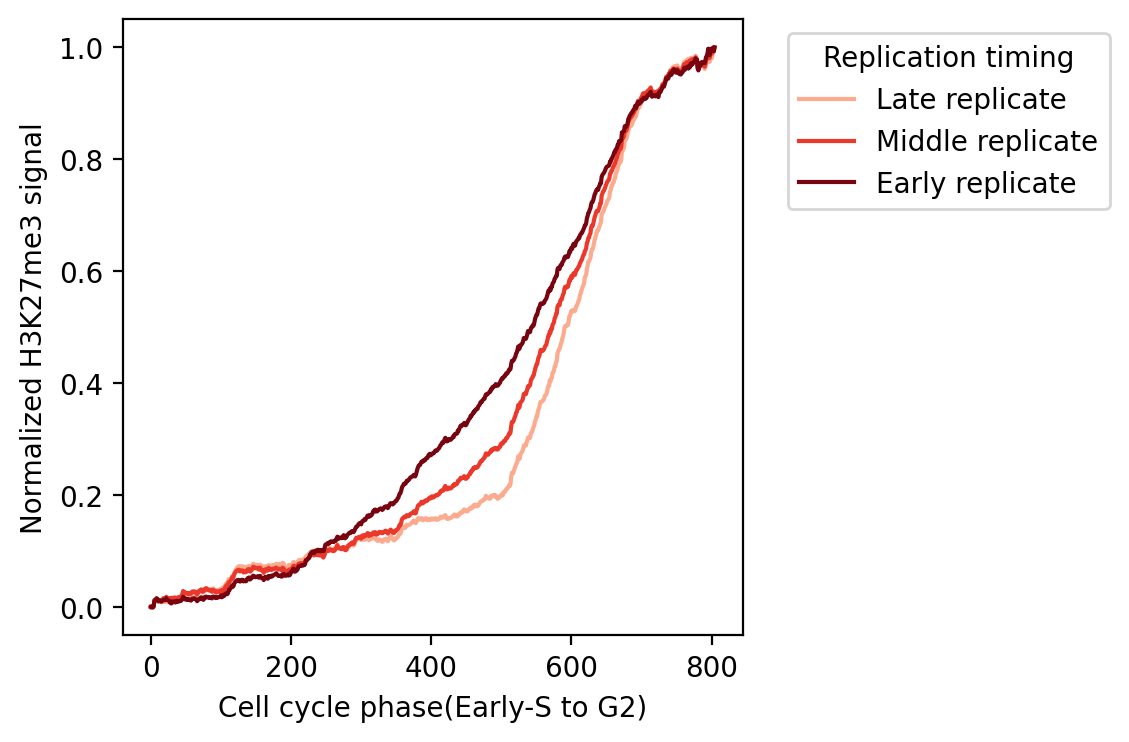

In [94]:
# atacbyrep
# plot each row into a line
plt.figure(figsize=(4,4))
#for row in ctbyrep.index:
for index,row in enumerate(ctbyrep.index):
    # min_max normalize on vec
    vec = ctbyrep.loc[row,:]
    vec = (vec - vec.min()) / (vec.max() - vec.min())
    #plt.plot(np.arange(ctbyrep.shape[1]),vec,label=row,c = plt.cm.Reds(row/8 + 0.2))
    plt.plot(np.arange(ctbyrep.shape[1]),vec,label=row,c = plt.cm.Reds(index/3 + 0.3))
    
# plt.xlabel("Cell cycle phase(Early-S to G1)")
plt.xlabel("Cell cycle phase(Early-S to G2)")
plt.ylabel("Normalized H3K27me3 signal")
plt.legend(title="Replication timing",bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("figures/h3k27me3_peak_signal_by_repli_time.pdf",bbox_inches="tight")

In [95]:
ctbyrep = (ctmat_order.reset_index()
             .merge(intersected, on=["chrom","start","end"], how="left")
             .drop(columns=["chrom","start","end"])
             .groupby("group")
             .mean())
ctbyrep.index = np.array(["Late replicate","Middle replicate","Early replicate"])

grouped = (ctmat_order.reset_index()
           .merge(intersected, on=["chrom","start","end"], how="left")
           .drop(columns=["chrom","start","end"])
           .groupby("group"))

mean = grouped.mean()
std = grouped.std()
count = grouped.count()

se = std / np.sqrt(count)
dof = count - 1
alpha = 0.05
t_values = t.ppf(1 - alpha/2, dof)
half_width = t_values * se
lower = mean - half_width
upper = mean + half_width
mean.index = ctbyrep.index
lower.index = ctbyrep.index
upper.index = ctbyrep.index
ctbyrep_with_ci = pd.concat({
    'mean': mean,
    'lower': lower,
    'upper': upper
}, axis=1)

print(ctbyrep_with_ci)

                      mean                                                    \
                     P2050     P1040     P7065     P6006     P2091     P2030   
Late replicate    0.147353  0.148248  0.147510  0.148152  0.148769  0.156325   
Middle replicate  0.119786  0.120558  0.119032  0.120068  0.120636  0.128968   
Early replicate   0.103055  0.103035  0.102298  0.102070  0.103461  0.110833   

                                                          ...     upper  \
                     P2022     P7063     P8047     P6073  ...     P1019   
Late replicate    0.156159  0.156214  0.158197  0.158111  ...  0.839546   
Middle replicate  0.128527  0.129090  0.130772  0.130306  ...  0.857002   
Early replicate   0.111772  0.112791  0.114623  0.114257  ...  0.879654   

                                                                              \
                     P3018     P6013    P10023     P8052     P1065     P1089   
Late replicate    0.836349  0.829301  0.835082  0.833721  0.834

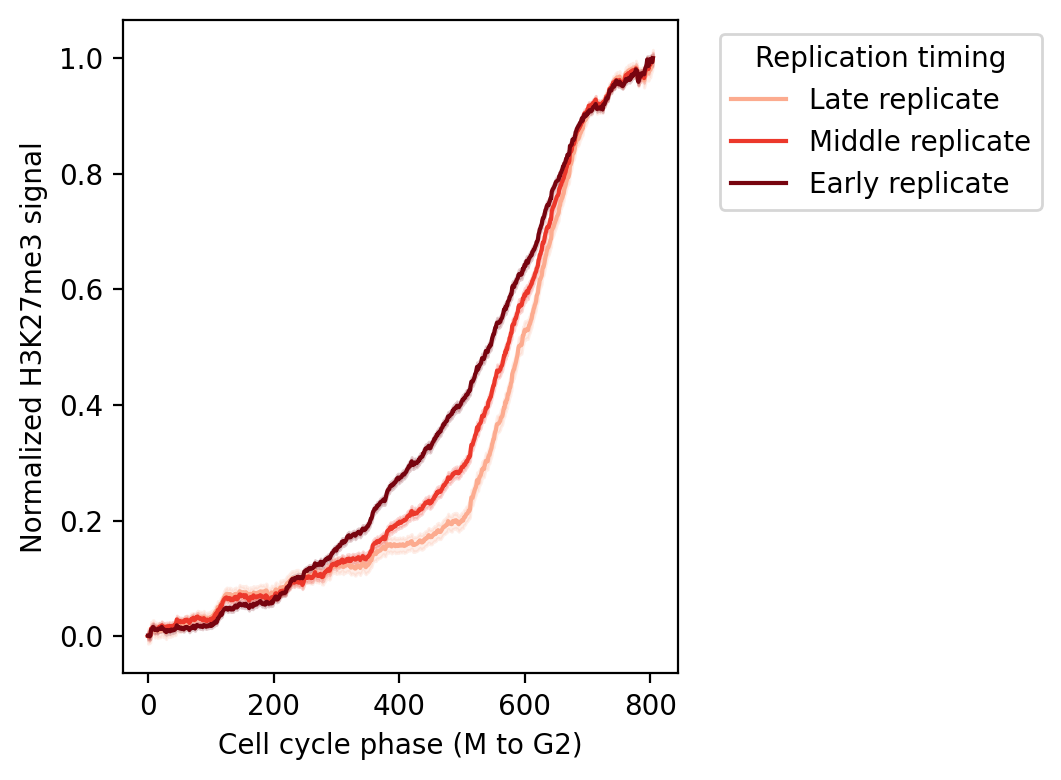

In [113]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(6.5, 4))

ct_mean = ctbyrep_with_ci['mean']
ct_upper = ctbyrep_with_ci['upper']
ct_lower = ctbyrep_with_ci['lower']

for i, row_name in enumerate(ct_mean.index):
    mean_vec = ct_mean.loc[row_name, :]
    upper_vec = ct_upper.loc[row_name, :]
    lower_vec = ct_lower.loc[row_name, :]
    vec_min = mean_vec.min()
    vec_max = mean_vec.max()
    
    norm_mean = (mean_vec - vec_min) / (vec_max - vec_min)
    norm_upper = (upper_vec - vec_min) / (vec_max - vec_min) 
    norm_lower = (lower_vec - vec_min) / (vec_max - vec_min) 

    x_values = np.arange(ct_mean.shape[1])
    color = plt.cm.Reds(i / 3 + 0.3)

    plt.plot(x_values, norm_mean, label=row_name, c=color)
    plt.fill_between(x_values, norm_lower, norm_upper, color=color, alpha=0.2)

plt.legend(title="Replication timing", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Cell cycle phase (M to G2)")
plt.ylabel("Normalized H3K27me3 signal")
plt.tight_layout(rect=[0, 0, 0.85, 1]) 

plt.savefig("figures/h3k27me3_peak_signal_by_repli_time_with_CI.pdf", bbox_inches="tight")

plt.show()